# Import Packages

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import json

from utils import cluster_topk_classes
from modules.models import KMeansModels, KMeansModelConfig 
from constants import PRODUCT_EMBEDDINGS_PATH, CLASS_EMBEDDINGS_PATH, RANDOM_STATE, DEVICE, CLEANED_GPC_PATH

## Read CSVs

In [2]:
df_products = pd.read_csv(PRODUCT_EMBEDDINGS_PATH)
df_classes = pd.read_csv(CLASS_EMBEDDINGS_PATH)
df_class = pd.read_csv(CLEANED_GPC_PATH)

## Load Embeddings

In [ ]:
products_embeddings = [json.loads(embedding) for embedding in df_products["embeddings"].tolist()]
classes_embeddings = [json.loads(embedding) for embedding in df_classes["embeddings"].tolist()]

## Visualize Embeddings

### Products Embeddings

C:\Users\os255022\AppData\Local\Temp\ipykernel_16136\4181610033.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(products[:, 0], products[:, 1], cmap="viridis")


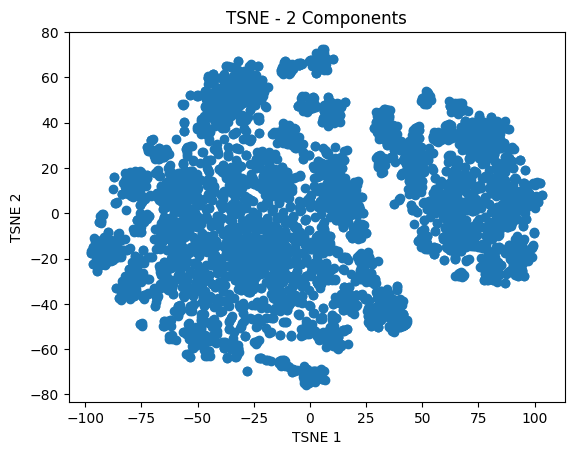

In [12]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=400, random_state=RANDOM_STATE)
products = tsne.fit_transform(np.array(products_embeddings))

plt.scatter(products[:, 0], products[:, 1], cmap="viridis")

plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE - 2 Components")
plt.show()

### Classes Embeddings

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=400, random_state=RANDOM_STATE)
classes = tsne.fit_transform(np.array(classes_embeddings))

plt.scatter(classes[:, 0], classes[:, 1], cmap="viridis")

plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE - 2 Components")
plt.show()

## Fit Model

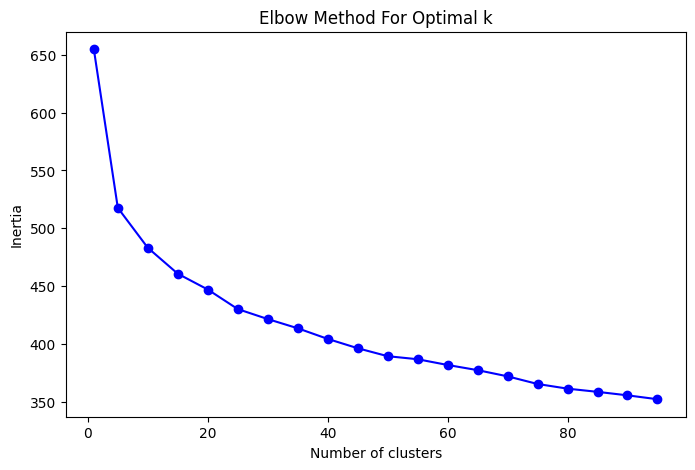

In [ ]:

inertia = []
K = [1] + list(range(5, 100, 5))

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(products_embeddings)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


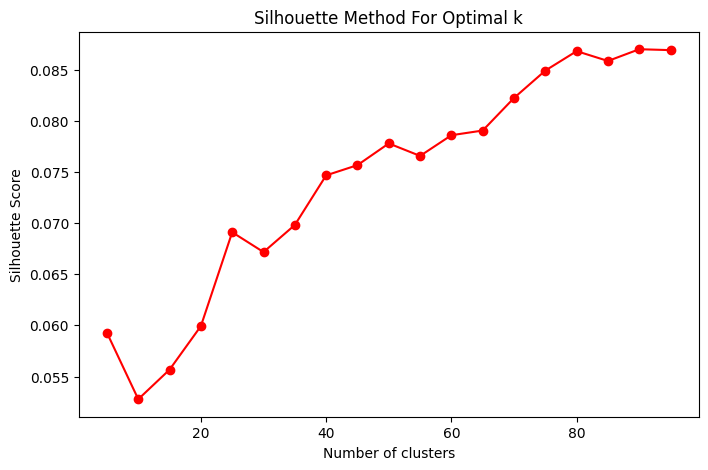

In [ ]:
sil_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(products_embeddings)
    if len(set(labels)) <= 1:
        continue
    sil_score = silhouette_score(products_embeddings, labels)
    sil_scores.append(sil_score)

plt.figure(figsize=(8,5))
plt.plot(K[1:], sil_scores, 'ro-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()


In [4]:
kmeans = KMeans(n_clusters=40, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(products_embeddings)

In [23]:
cluster_items = {i: [] for i in range(kmeans.n_clusters)}
for i, (embedding, label) in enumerate(zip(products_embeddings, labels)):
    cluster_items[label].append((i, embedding))

In [ ]:
kmeans.cluster_centers_[0],

array([ 0.01902479,  0.02399589,  0.00179847, ..., -0.00280312,
       -0.02839753,  0.03732116], shape=(1024,))

In [25]:
cluster_embeddings = torch.tensor([kmeans.cluster_centers_[0]], dtype=torch.float16, device=DEVICE)
classes_embeddings = torch.tensor(classes_embeddings, dtype=torch.float16, device=DEVICE)
classes = cluster_topk_classes(cluster_embeddings, classes_embeddings, 3)

C:\Users\os255022\AppData\Local\Temp\ipykernel_7564\3547667029.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes_embeddings = torch.tensor(classes_embeddings, dtype=torch.float16, device=DEVICE)


In [26]:
classes = [item for sublist in classes.tolist() for item in sublist]

In [27]:
classes

[3345, 3300, 1508]

In [29]:
cluster_items[0]

[(46,
  [0.0182037353515625,
   0.00894927978515625,
   -0.005645751953125,
   -0.045074462890625,
   0.0189971923828125,
   -0.00550079345703125,
   -0.0249176025390625,
   0.047637939453125,
   0.00414276123046875,
   -0.017578125,
   0.0242462158203125,
   0.0206756591796875,
   -0.0268096923828125,
   -0.0264739990234375,
   -0.0252227783203125,
   -0.0273284912109375,
   -0.04931640625,
   0.0235137939453125,
   -0.0230560302734375,
   -0.0188140869140625,
   0.04913330078125,
   0.0094146728515625,
   -0.03741455078125,
   -0.021942138671875,
   -0.00899505615234375,
   -0.015533447265625,
   -0.027252197265625,
   -0.0333251953125,
   -0.024932861328125,
   -0.03143310546875,
   -0.0079345703125,
   0.029083251953125,
   -0.01438140869140625,
   -0.042266845703125,
   -0.020263671875,
   0.032958984375,
   0.038330078125,
   0.059600830078125,
   -0.027557373046875,
   0.05499267578125,
   -0.0011663436889648438,
   0.0230865478515625,
   0.035552978515625,
   -0.015129089355468

In [19]:
from collections import Counter

counter = Counter(classes)

mode, count = counter.most_common(1)[0]

In [20]:
mode, count

(3345, 1)

In [22]:
df_class[df_class["id"]==3345]

,id,class_name,description
3345,3345,bath additives consumer lifestage unidentified,includes any products that can be described ob...


In [ ]:
df_products